# Supabase 데이터 분석 템플릿

이 노트북은 Supabase에서 데이터를 불러와 분석하는 템플릿입니다.

## 사용 방법
1. 아래 셀에서 Supabase 연결 정보를 설정하세요
2. 필요한 테이블에서 데이터를 불러옵니다
3. pandas DataFrame으로 변환하여 분석합니다.

## 0. 필요한 패키지 설치

⚠️ **중요**: 아래 셀을 먼저 실행하여 필요한 패키지를 설치하세요.


In [1]:
# 필요한 패키지 설치 (Jupyter Notebook 환경에 설치)
# ⚠️ 이 셀을 먼저 실행하세요!
import sys
import subprocess

def install_package(package):
    """패키지를 현재 Python 환경에 설치"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

# 필요한 패키지 목록
required_packages = [
    "supabase>=2.0.0",
    "python-dotenv>=1.0.0",
    "toml>=0.10.2",  # TOML 파일 읽기용
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "plotly"
]

print("📦 필요한 패키지를 설치하는 중...")
for package in required_packages:
    try:
        install_package(package)
        print(f"✅ {package} 설치 완료")
    except Exception as e:
        print(f"⚠️ {package} 설치 실패: {e}")

print("\n✅ 패키지 설치 완료! 이제 아래 셀(Cell 4)을 실행하세요.")


📦 필요한 패키지를 설치하는 중...
✅ supabase>=2.0.0 설치 완료
✅ python-dotenv>=1.0.0 설치 완료
✅ toml>=0.10.2 설치 완료
✅ pandas 설치 완료
✅ numpy 설치 완료
✅ matplotlib 설치 완료
✅ seaborn 설치 완료
✅ plotly 설치 완료

✅ 패키지 설치 완료! 이제 아래 셀(Cell 4)을 실행하세요.


## 1. 필요한 라이브러리 import


In [2]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import Optional, List, Dict
import os
from pathlib import Path
import toml  # TOML 파일 읽기용

# Supabase 클라이언트
from supabase import create_client, Client

# 데이터 시각화 (선택사항)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 설정 (matplotlib 사용 시)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

print("✅ 라이브러리 import 완료")


✅ 라이브러리 import 완료


## 3. Supabase 클라이언트 생성


In [3]:
def get_supabase_client(url: Optional[str] = None, key: Optional[str] = None) -> Optional[Client]:
    """
    Supabase 클라이언트를 생성합니다.
    우선순위: 파라미터 > 전역 변수 > TOML 파일 > 환경변수
    
    Args:
        url: Supabase URL (없으면 전역 변수 또는 TOML에서 읽음)
        key: Supabase Key (없으면 전역 변수 또는 TOML에서 읽음)
    
    Returns:
        Supabase 클라이언트 객체 또는 None
    """
    supabase_url = url
    supabase_key = key
    
    # 1. 파라미터가 없으면 전역 변수 확인 (기본값이 아닌 경우만)
    if not supabase_url:
        try:
            if 'SUPABASE_URL' in globals() and SUPABASE_URL and SUPABASE_URL != "your_supabase_url_here":
                supabase_url = SUPABASE_URL
        except:
            pass
    
    if not supabase_key:
        try:
            if 'SUPABASE_KEY' in globals() and SUPABASE_KEY and SUPABASE_KEY != "your_supabase_key_here":
                supabase_key = SUPABASE_KEY
        except:
            pass
    
    # 2. 전역 변수도 없거나 기본값이면 TOML 파일에서 직접 읽기 시도
    if not supabase_url or not supabase_key or supabase_url == "your_supabase_url_here" or supabase_key == "your_supabase_key_here":
        # 여러 경로 시도 (상대 경로, 절대 경로)
        possible_paths = [
            Path(".streamlit/secrets.toml"),
            Path("../.streamlit/secrets.toml"),
            Path("../../.streamlit/secrets.toml"),
        ]
        
        for secrets_path in possible_paths:
            if secrets_path.exists():
                try:
                    secrets = toml.load(secrets_path)
                    if not supabase_url or supabase_url == "your_supabase_url_here":
                        supabase_url = secrets.get("SUPABASE_URL") or supabase_url
                    if not supabase_key or supabase_key == "your_supabase_key_here":
                        supabase_key = secrets.get("SUPABASE_KEY") or supabase_key
                    if supabase_url and supabase_key and supabase_url != "your_supabase_url_here" and supabase_key != "your_supabase_key_here":
                        print(f"✅ TOML 파일에서 설정을 불러왔습니다. ({secrets_path})")
                        break
                except Exception as e:
                    print(f"⚠️ TOML 파일 읽기 실패 ({secrets_path}): {e}")
    
    # 3. 환경변수에서 가져오기
    if not supabase_url or supabase_url == "your_supabase_url_here":
        supabase_url = os.getenv("SUPABASE_URL") or supabase_url
    if not supabase_key or supabase_key == "your_supabase_key_here":
        supabase_key = os.getenv("SUPABASE_KEY") or supabase_key
    
    # 4. 최종 검증
    if not supabase_url or not supabase_key or supabase_url == "your_supabase_url_here" or supabase_key == "your_supabase_key_here":
        print("⚠️ Supabase 설정이 누락되었습니다.")
        print("   다음 중 하나를 설정하세요:")
        print("   1. .streamlit/secrets.toml 파일에 SUPABASE_URL과 SUPABASE_KEY 추가")
        print("   2. 환경변수 SUPABASE_URL, SUPABASE_KEY 설정")
        print("   3. 이 함수 호출 시 파라미터로 전달: get_supabase_client(url='...', key='...')")
        return None
    
    try:
        supabase = create_client(supabase_url, supabase_key)
        print("✅ Supabase 클라이언트 생성 성공")
        return supabase
    except Exception as e:
        print(f"❌ Supabase 클라이언트 생성 실패: {e}")
        return None

# 클라이언트 생성
supabase = get_supabase_client()


✅ TOML 파일에서 설정을 불러왔습니다. (..\.streamlit\secrets.toml)
✅ Supabase 클라이언트 생성 성공


## 4. 데이터 불러오기 함수들

주요 테이블에서 데이터를 불러오는 함수들을 정의합니다.


In [4]:
def fetch_event_logs(
    supabase: Client,
    user_id: Optional[str] = None,
    event_type: Optional[str] = None,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    limit: int = 1000
) -> pd.DataFrame:
    """
    event_logs 테이블에서 데이터를 가져옵니다.
    
    Args:
        supabase: Supabase 클라이언트
        user_id: 특정 사용자 ID로 필터링 (선택사항)
        event_type: 특정 이벤트 타입으로 필터링 (선택사항)
        start_date: 시작 날짜 (YYYY-MM-DD 형식, 선택사항)
        end_date: 종료 날짜 (YYYY-MM-DD 형식, 선택사항)
        limit: 가져올 최대 레코드 수 (기본값: 1000)
    
    Returns:
        pandas DataFrame
    """
    if not supabase:
        print("⚠️ Supabase 클라이언트가 없습니다.")
        return pd.DataFrame()
    
    try:
        query = supabase.table("event_logs").select("*")
        
        # 필터링 조건 추가
        if user_id:
            query = query.eq("user_id", user_id)
        if event_type:
            query = query.eq("event_type", event_type)
        if start_date:
            query = query.gte("created_at", start_date)
        if end_date:
            query = query.lte("created_at", end_date)
        
        # 정렬 및 제한
        query = query.order("created_at", desc=True).limit(limit)
        
        response = query.execute()
        
        if response.data:
            df = pd.DataFrame(response.data)
            # 날짜 컬럼 변환 (ISO8601 형식 지원)
            if 'created_at' in df.columns:
                df['created_at'] = pd.to_datetime(df['created_at'], format='ISO8601', errors='coerce')
            print(f"✅ {len(df)}개의 이벤트 로그를 불러왔습니다.")
            return df
        else:
            print("ℹ️ 데이터가 없습니다.")
            return pd.DataFrame()
            
    except Exception as e:
        print(f"❌ 이벤트 로그 조회 실패: {e}")
        return pd.DataFrame()


In [5]:
def fetch_news(
    supabase: Client,
    limit: int = 1000,
    min_impact_score: Optional[int] = None,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None
) -> pd.DataFrame:
    """
    news 테이블에서 데이터를 가져옵니다.
    
    Args:
        supabase: Supabase 클라이언트
        limit: 가져올 최대 레코드 수 (기본값: 1000)
        min_impact_score: 최소 impact_score (선택사항)
        start_date: 시작 날짜 (YYYY-MM-DD 형식, 선택사항)
        end_date: 종료 날짜 (YYYY-MM-DD 형식, 선택사항)
    
    Returns:
        pandas DataFrame
    """
    if not supabase:
        print("⚠️ Supabase 클라이언트가 없습니다.")
        return pd.DataFrame()
    
    try:
        query = supabase.table("news").select("*")
        
        # 삭제되지 않은 뉴스만
        query = query.is_("deleted_at", "null")
        
        # 필터링 조건 추가
        if min_impact_score is not None:
            query = query.gte("impact_score", min_impact_score)
        if start_date:
            query = query.gte("published_at", start_date)
        if end_date:
            query = query.lte("published_at", end_date)
        
        # 정렬 및 제한
        query = query.order("published_at", desc=True).limit(limit)
        
        response = query.execute()
        
        if response.data:
            df = pd.DataFrame(response.data)
            # 날짜 컬럼 변환 (ISO8601 형식 지원)
            if 'published_at' in df.columns:
                df['published_at'] = pd.to_datetime(df['published_at'], format='ISO8601', errors='coerce')
            if 'created_at' in df.columns:
                df['created_at'] = pd.to_datetime(df['created_at'], format='ISO8601', errors='coerce')
            print(f"✅ {len(df)}개의 뉴스를 불러왔습니다.")
            return df
        else:
            print("ℹ️ 데이터가 없습니다.")
            return pd.DataFrame()
            
    except Exception as e:
        print(f"❌ 뉴스 조회 실패: {e}")
        return pd.DataFrame()


In [6]:
def fetch_custom_table(
    supabase: Client,
    table_name: str,
    columns: str = "*",
    filters: Optional[Dict] = None,
    order_by: Optional[str] = None,
    desc: bool = True,
    limit: int = 1000
) -> pd.DataFrame:
    """
    임의의 테이블에서 데이터를 가져옵니다.
    
    Args:
        supabase: Supabase 클라이언트
        table_name: 테이블 이름
        columns: 선택할 컬럼 (기본값: "*")
        filters: 필터링 조건 딕셔너리 (예: {"column": "value"})
        order_by: 정렬 기준 컬럼 (선택사항)
        desc: 내림차순 여부 (기본값: True)
        limit: 가져올 최대 레코드 수 (기본값: 1000)
    
    Returns:
        pandas DataFrame
    """
    if not supabase:
        print("⚠️ Supabase 클라이언트가 없습니다.")
        return pd.DataFrame()
    
    try:
        query = supabase.table(table_name).select(columns)
        
        # 필터링 조건 추가
        if filters:
            for column, value in filters.items():
                if isinstance(value, list):
                    query = query.in_(column, value)
                else:
                    query = query.eq(column, value)
        
        # 정렬
        if order_by:
            query = query.order(order_by, desc=desc)
        
        # 제한
        query = query.limit(limit)
        
        response = query.execute()
        
        if response.data:
            df = pd.DataFrame(response.data)
            print(f"✅ {len(df)}개의 레코드를 불러왔습니다. (테이블: {table_name})")
            return df
        else:
            print(f"ℹ️ {table_name} 테이블에 데이터가 없습니다.")
            return pd.DataFrame()
            
    except Exception as e:
        print(f"❌ {table_name} 테이블 조회 실패: {e}")
        return pd.DataFrame()


## 5. 데이터 불러오기 예제


In [7]:
# 예제 1: 최근 7일간의 이벤트 로그 불러오기
end_date = datetime.now()
start_date = end_date - timedelta(days=7)

event_logs_df = fetch_event_logs(
    supabase=supabase,
    start_date=start_date.strftime("%Y-%m-%d"),
    end_date=end_date.strftime("%Y-%m-%d"),
    limit=5000
)

print(f"\n데이터 크기: {event_logs_df.shape}")
print(f"\n컬럼 목록:")
print(event_logs_df.columns.tolist())
event_logs_df.head()


✅ 1000개의 이벤트 로그를 불러왔습니다.

데이터 크기: (1000, 11)

컬럼 목록:
['event_id', 'event_time', 'session_id', 'dialogue_id', 'event_name', 'surface', 'source', 'ref_id', 'payload', 'user_id', 'created_at']


,event_id,event_time,session_id,dialogue_id,event_name,surface,source,ref_id,payload,user_id,created_at
0,4751,2025-11-19T21:16:50.645663,None,NaN,session_start,home,None,None,{'user_id': '8af6938c-97e5-46a2-a140-31eea062e...,8af6938c-97e5-46a2-a140-31eea062eda5,2025-11-19 21:16:50.807029+00:00
1,4750,2025-11-19T21:11:50.163491,None,NaN,session_start,home,None,None,{'user_id': '8af6938c-97e5-46a2-a140-31eea062e...,8af6938c-97e5-46a2-a140-31eea062eda5,2025-11-19 21:11:50.507388+00:00
2,4749,2025-11-19T21:06:50.739036,None,NaN,session_start,home,None,None,{'user_id': '8af6938c-97e5-46a2-a140-31eea062e...,8af6938c-97e5-46a2-a140-31eea062eda5,2025-11-19 21:06:50.883070+00:00
3,4748,2025-11-19T21:01:50.15032,None,NaN,session_start,home,None,None,{'user_id': '8af6938c-97e5-46a2-a140-31eea062e...,8af6938c-97e5-46a2-a140-31eea062eda5,2025-11-19 21:01:50.879515+00:00
4,4747,2025-11-19T20:56:50.687094,None,NaN,session_start,home,None,None,{'user_id': '8af6938c-97e5-46a2-a140-31eea062e...,8af6938c-97e5-46a2-a140-31eea062eda5,2025-11-19 20:56:50.876110+00:00


## 6. Payload 분석 도구

이벤트 로그의 `payload` 컬럼에는 대부분의 상세 데이터가 JSON 형식으로 저장되어 있습니다. 
아래 함수들을 사용하여 payload를 펼쳐서 분석할 수 있습니다.


In [8]:
import json
from collections import Counter

def expand_payload(df: pd.DataFrame, payload_column: str = 'payload') -> pd.DataFrame:
    """
    DataFrame의 payload 컬럼을 JSON으로 파싱하여 펼쳐서 새로운 컬럼으로 추가합니다.
    
    Args:
        df: 원본 DataFrame
        payload_column: payload가 저장된 컬럼 이름 (기본값: 'payload')
    
    Returns:
        payload가 펼쳐진 새로운 DataFrame
    """
    if payload_column not in df.columns:
        print(f"⚠️ '{payload_column}' 컬럼이 존재하지 않습니다.")
        return df.copy()
    
    df_expanded = df.copy()
    
    # payload를 JSON으로 파싱
    def parse_payload(payload):
        if pd.isna(payload) or payload == '' or payload is None:
            return {}
        if isinstance(payload, dict):
            return payload
        if isinstance(payload, str):
            try:
                return json.loads(payload)
            except (json.JSONDecodeError, TypeError):
                return {}
        return {}
    
    payloads = df_expanded[payload_column].apply(parse_payload)
    
    # payload를 DataFrame으로 변환 (json_normalize 사용)
    if len(payloads) > 0 and any(payloads):
        payload_df = pd.json_normalize(payloads)
        
        # 컬럼 이름에 prefix 추가 (payload_)
        payload_df.columns = [f'payload_{col}' if not col.startswith('payload_') else col 
                             for col in payload_df.columns]
        
        # 원본 DataFrame과 결합
        df_expanded = pd.concat([df_expanded, payload_df], axis=1)
        
        print(f"✅ Payload를 펼쳐서 {len(payload_df.columns)}개의 컬럼을 추가했습니다.")
        print(f"   추가된 컬럼: {list(payload_df.columns)}")
    else:
        print("ℹ️ 파싱 가능한 payload가 없습니다.")
    
    return df_expanded


def show_payload_examples(df: pd.DataFrame, payload_column: str = 'payload', 
                         event_name: Optional[str] = None, n_examples: int = 5) -> None:
    """
    payload의 예시를 보기 좋게 출력합니다.
    
    Args:
        df: DataFrame
        payload_column: payload 컬럼 이름
        event_name: 특정 이벤트 이름으로 필터링 (선택사항)
        n_examples: 보여줄 예시 개수
    """
    if payload_column not in df.columns:
        print(f"⚠️ '{payload_column}' 컬럼이 존재하지 않습니다.")
        return
    
    # 필터링
    display_df = df.copy()
    if event_name:
        if 'event_name' in display_df.columns:
            display_df = display_df[display_df['event_name'] == event_name]
        else:
            print(f"⚠️ 'event_name' 컬럼이 없어 필터링할 수 없습니다.")
    
    if len(display_df) == 0:
        print("ℹ️ 표시할 데이터가 없습니다.")
        return
    
    # payload가 있는 행만 선택
    display_df = display_df[display_df[payload_column].notna() & (display_df[payload_column] != '')]
    
    if len(display_df) == 0:
        print("ℹ️ payload가 있는 데이터가 없습니다.")
        return
    
    # n_examples개만 선택
    display_df = display_df.head(n_examples)
    
    print(f"\n📋 Payload 예시 ({len(display_df)}개):")
    if event_name:
        print(f"   이벤트 타입: {event_name}")
    print("=" * 80)
    
    for idx, row in display_df.iterrows():
        print(f"\n[예시 {idx + 1}]")
        if 'event_name' in row:
            print(f"  이벤트: {row['event_name']}")
        if 'event_time' in row:
            print(f"  시간: {row['event_time']}")
        if 'user_id' in row:
            print(f"  사용자 ID: {row['user_id']}")
        
        print(f"  Payload:")
        payload = row[payload_column]
        
        # JSON 파싱 시도
        if isinstance(payload, str):
            try:
                payload_dict = json.loads(payload)
                print(json.dumps(payload_dict, indent=4, ensure_ascii=False))
            except:
                print(f"    {payload}")
        elif isinstance(payload, dict):
            print(json.dumps(payload, indent=4, ensure_ascii=False))
        else:
            print(f"    {payload}")
        
        print("-" * 80)


def analyze_payload_structure(df: pd.DataFrame, payload_column: str = 'payload') -> pd.DataFrame:
    """
    payload의 구조를 분석하여 어떤 키들이 있는지, 각 키의 데이터 타입과 예시 값을 보여줍니다.
    
    Args:
        df: DataFrame
        payload_column: payload 컬럼 이름
    
    Returns:
        payload 구조 분석 결과 DataFrame
    """
    if payload_column not in df.columns:
        print(f"⚠️ '{payload_column}' 컬럼이 존재하지 않습니다.")
        return pd.DataFrame()
    
    # payload 파싱
    def parse_payload(payload):
        if pd.isna(payload) or payload == '' or payload is None:
            return {}
        if isinstance(payload, dict):
            return payload
        if isinstance(payload, str):
            try:
                return json.loads(payload)
            except:
                return {}
        return {}
    
    payloads = df[payload_column].apply(parse_payload)
    
    # 모든 키 수집
    all_keys = set()
    key_types = {}
    key_examples = {}
    
    for payload in payloads:
        if isinstance(payload, dict):
            for key, value in payload.items():
                all_keys.add(key)
                if key not in key_types:
                    key_types[key] = []
                key_types[key].append(type(value).__name__)
                
                # 예시 값 저장 (처음 3개만)
                if key not in key_examples:
                    key_examples[key] = []
                if len(key_examples[key]) < 3 and value is not None:
                    key_examples[key].append(str(value)[:100])  # 최대 100자
    
    # 결과 DataFrame 생성
    result_data = []
    for key in sorted(all_keys):
        types = Counter(key_types[key])
        most_common_type = types.most_common(1)[0][0] if types else 'unknown'
        type_distribution = dict(types)
        
        result_data.append({
            'key': key,
            'most_common_type': most_common_type,
            'type_distribution': type_distribution,
            'examples': key_examples.get(key, []),
            'frequency': len([p for p in payloads if isinstance(p, dict) and key in p])
        })
    
    result_df = pd.DataFrame(result_data)
    result_df = result_df.sort_values('frequency', ascending=False)
    
    print(f"📊 Payload 구조 분석 결과:")
    print(f"   총 {len(all_keys)}개의 고유한 키가 발견되었습니다.")
    print(f"   Payload가 있는 레코드: {len([p for p in payloads if p])}개")
    print()
    
    return result_df

print("✅ Payload 분석 도구 함수들이 준비되었습니다.")


✅ Payload 분석 도구 함수들이 준비되었습니다.


## 7. Payload 분석 예제


In [9]:
# 예제 1: Payload 구조 분석
# 어떤 키들이 있는지, 각 키의 데이터 타입과 빈도를 확인합니다.

payload_structure = analyze_payload_structure(event_logs_df, payload_column='payload')
payload_structure


📊 Payload 구조 분석 결과:
   총 34개의 고유한 키가 발견되었습니다.
   Payload가 있는 레코드: 1000개



,key,most_common_type,type_distribution,examples,frequency
32,user_id,str,{'str': 1000},"[8af6938c-97e5-46a2-a140-31eea062eda5, 8af6938...",1000
26,surface,str,{'str': 1000},"[home, home, home]",1000
19,note,str,{'str': 626},"[MVP session start, MVP session start, MVP ses...",626
30,ua,dict,{'dict': 561},"[{}, {}, {}]",561
24,source,str,{'str': 339},"[news_highlight, news_highlight, chat_button]",339
17,message,str,{'str': 271},"['기업' 용어를 설명해주세요, '기업' 용어를 설명해주세요, 삼성 관련된 뉴스]",271
18,news_id,int,{'int': 186},"[463, 463, 463]",186
14,latency_ms,int,{'int': 152},"[4281, 4281, 3]",152
29,title,str,{'str': 130},"[역대급 호황에도 대기업 기부는 ‘찔끔’ 늘어…삼성전자는 감소, 역대급 호황에도 대...",130
0,answer_len,int,{'int': 108},"[210, 240, 451]",108


In [10]:
# 예제 2: 특정 이벤트 타입의 payload 예시 보기
# event_name 컬럼이 있다면 특정 이벤트 타입만 필터링할 수 있습니다.

# 먼저 어떤 이벤트 타입들이 있는지 확인
if 'event_name' in event_logs_df.columns:
    print("📋 이벤트 타입 목록:")
    event_counts = event_logs_df['event_name'].value_counts()
    print(event_counts)
    print("\n" + "="*80)
    
    # 가장 많이 발생한 이벤트 타입의 payload 예시 보기
    most_common_event = event_counts.index[0]
    print(f"\n가장 많이 발생한 이벤트 타입: '{most_common_event}' ({event_counts.iloc[0]}회)")
    show_payload_examples(event_logs_df, event_name=most_common_event, n_examples=3)
else:
    # event_name이 없으면 전체 payload 예시 보기
    show_payload_examples(event_logs_df, n_examples=5)


📋 이벤트 타입 목록:
event_name
session_start               561
chat_question               137
chat_response                73
news_detail_open             65
news_click                   43
glossary_answer              35
news_detail_back             34
news_selected_from_chat      18
news_search_from_chat        14
news_url_added_from_chat     12
glossary_click                7
chat_reset                    1
Name: count, dtype: int64


가장 많이 발생한 이벤트 타입: 'session_start' (561회)

📋 Payload 예시 (3개):
   이벤트 타입: session_start

[예시 1]
  이벤트: session_start
  시간: 2025-11-19T21:16:50.645663
  사용자 ID: 8af6938c-97e5-46a2-a140-31eea062eda5
  Payload:
{
    "user_id": "8af6938c-97e5-46a2-a140-31eea062eda5",
    "surface": "home",
    "ua": {},
    "note": "MVP session start"
}
--------------------------------------------------------------------------------

[예시 2]
  이벤트: session_start
  시간: 2025-11-19T21:11:50.163491
  사용자 ID: 8af6938c-97e5-46a2-a140-31eea062eda5
  Payload:
{
    "user_id": "8af6938c-97

In [11]:
# 예제 3: Payload를 펼쳐서 분석하기
# payload의 내용을 별도 컬럼으로 펼쳐서 일반적인 DataFrame처럼 분석할 수 있습니다.

event_logs_expanded = expand_payload(event_logs_df, payload_column='payload')

print(f"\n원본 컬럼 수: {len(event_logs_df.columns)}")
print(f"펼친 후 컬럼 수: {len(event_logs_expanded.columns)}")
print(f"\n펼쳐진 payload 컬럼들:")
payload_cols = [col for col in event_logs_expanded.columns if col.startswith('payload_')]
print(payload_cols)

# 펼쳐진 데이터 미리보기
event_logs_expanded.head()


✅ Payload를 펼쳐서 46개의 컬럼을 추가했습니다.
   추가된 컬럼: ['payload_user_id', 'payload_surface', 'payload_note', 'payload_back_process_ms', 'payload_duration_sec', 'payload_max_depth_pct', 'payload_news_id', 'payload_source', 'payload_message', 'payload_answer_len', 'payload_via', 'payload_latency_ms', 'payload_response', 'payload_term', 'payload_rag_info', 'payload_perf_steps.explanation_ms', 'payload_perf_steps.total_ms', 'payload_perf_steps.answer_length', 'payload_click_count', 'payload_title', 'payload_article_id', 'payload_cache_hit', 'payload_highlight_cache_hit', 'payload_terms_cache_hit', 'payload_perf_steps.highlight_ms', 'payload_perf_steps.terms_filter_ms', 'payload_perf_steps.terms_count', 'payload_perf_steps.content_length', 'payload_perf_steps.highlighted_length', 'payload_search_keyword', 'payload_url', 'payload_article_date', 'payload_keyword', 'payload_found_count', 'payload_supabase_results', 'payload_local_results', 'payload_article_ids', 'payload_api_info.model', 'payload_api_inf

,event_id,event_time,session_id,dialogue_id,event_name,surface,source,ref_id,payload,user_id,...,payload_article_ids,payload_api_info.model,payload_api_info.tokens.input,payload_api_info.tokens.output,payload_api_info.tokens.total,payload_api_info.api_params.temperature,payload_api_info.api_params.max_tokens,payload_click_process_ms,payload_content_length,payload_api_info.via
0,4751,2025-11-19T21:16:50.645663,None,NaN,session_start,home,None,None,{'user_id': '8af6938c-97e5-46a2-a140-31eea062e...,8af6938c-97e5-46a2-a140-31eea062eda5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4750,2025-11-19T21:11:50.163491,None,NaN,session_start,home,None,None,{'user_id': '8af6938c-97e5-46a2-a140-31eea062e...,8af6938c-97e5-46a2-a140-31eea062eda5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4749,2025-11-19T21:06:50.739036,None,NaN,session_start,home,None,None,{'user_id': '8af6938c-97e5-46a2-a140-31eea062e...,8af6938c-97e5-46a2-a140-31eea062eda5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4748,2025-11-19T21:01:50.15032,None,NaN,session_start,home,None,None,{'user_id': '8af6938c-97e5-46a2-a140-31eea062e...,8af6938c-97e5-46a2-a140-31eea062eda5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4747,2025-11-19T20:56:50.687094,None,NaN,session_start,home,None,None,{'user_id': '8af6938c-97e5-46a2-a140-31eea062e...,8af6938c-97e5-46a2-a140-31eea062eda5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# 예제 4: 펼쳐진 payload 컬럼으로 분석하기
# 이제 일반적인 pandas 분석을 수행할 수 있습니다.

if len(payload_cols) > 0:
    print("📊 Payload 컬럼별 데이터 분포:")
    print("="*80)
    
    for col in payload_cols[:10]:  # 처음 10개만 표시
        print(f"\n[{col}]")
        if event_logs_expanded[col].dtype == 'object':
            # 문자열/객체 타입인 경우
            value_counts = event_logs_expanded[col].value_counts().head(5)
            print(f"  상위 5개 값:")
            for val, count in value_counts.items():
                print(f"    - {val}: {count}회")
        else:
            # 숫자 타입인 경우
            print(f"  평균: {event_logs_expanded[col].mean():.2f}")
            print(f"  중앙값: {event_logs_expanded[col].median():.2f}")
            print(f"  최소값: {event_logs_expanded[col].min()}")
            print(f"  최대값: {event_logs_expanded[col].max()}")
else:
    print("ℹ️ 펼쳐진 payload 컬럼이 없습니다.")


📊 Payload 컬럼별 데이터 분포:

[payload_user_id]
  상위 5개 값:
    - 8af6938c-97e5-46a2-a140-31eea062eda5: 445회
    - b355f8f8-d62e-4999-bea9-2528f7f9f745: 120회
    - d9baaa70-24ea-47e5-8bb7-c326e9506f8c: 102회
    - 24b94780-ed73-47a9-9198-2b7a886cd470: 43회
    - b3a3a2cd-3430-4f27-a5bd-3724f18c33db: 22회

[payload_surface]
  상위 5개 값:
    - home: 604회
    - sidebar: 283회
    - detail: 113회

[payload_note]
  상위 5개 값:
    - MVP session start: 561회
    - 기사 렌더링 완료: 65회

[payload_back_process_ms]
  평균: 0.06
  중앙값: 0.00
  최소값: 0.0
  최대값: 1.0

[payload_duration_sec]
  평균: 66.23
  중앙값: 8.41
  최소값: 2.36
  최대값: 1048.35

[payload_max_depth_pct]
  평균: 0.00
  중앙값: 0.00
  최소값: 0.0
  최대값: 0.0

[payload_news_id]
  평균: -75663.92
  중앙값: 464.00
  최소값: -847992.0
  최대값: 496.0

[payload_source]
  상위 5개 값:
    - chat: 264회
    - list: 43회
    - chat_button: 18회
    - news_highlight: 14회

[payload_message]
  상위 5개 값:
    - 안녕: 45회
    - 융자: 37회
    - 관세: 32회
    - 삼성 관련 뉴스 보여줘: 11회
    - https://www.hani.co.kr/arti/econ

## 8. Glossary 인기 항목 분석



📊 Glossary 인기 항목 Top 10
   총 12개의 고유한 glossary 항목이 발견되었습니다.
   총 42개의 glossary 관련 이벤트가 있습니다.


Top 10 목록:
   1. 관세: 17회
   2. EB: 6회
   3. 종가: 4회
   4. 코스피: 4회
   5. 기업: 2회
   6. 헤지: 2회
   7. 이자: 2회
   8. OECD: 1회
   9. 누진세: 1회
  10. 종부세: 1회


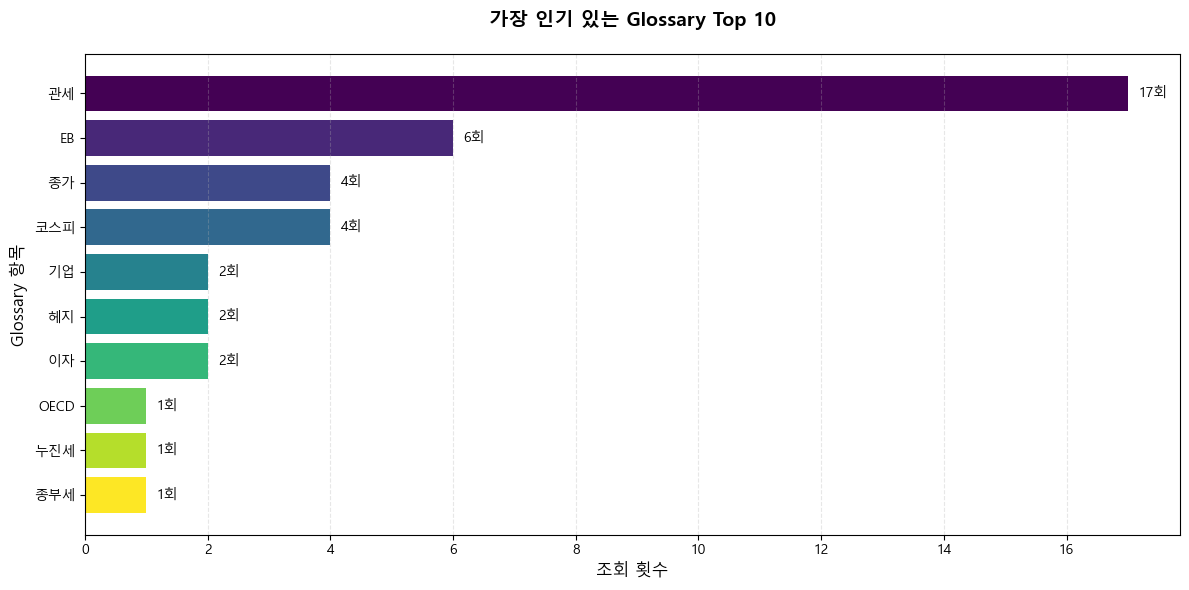



📋 Top 10 데이터프레임:
   glossary_term  count  percentage
1             관세     17       40.48
2             EB      6       14.29
3             종가      4        9.52
4            코스피      4        9.52
5             기업      2        4.76
6             헤지      2        4.76
7             이자      2        4.76
8           OECD      1        2.38
9            누진세      1        2.38
10           종부세      1        2.38


In [13]:
# 예제: 가장 인기 있는 Glossary Top 10 바 그래프
# payload_term 컬럼에서 glossary 항목들을 카운트하여 시각화합니다.

# payload가 펼쳐진 데이터가 필요합니다 (Cell 18 실행 필요)
if 'event_logs_expanded' not in globals():
    print("⚠️ 먼저 Cell 18을 실행하여 event_logs_expanded를 생성하세요.")
else:
    # payload_term 컬럼 확인
    if 'payload_term' in event_logs_expanded.columns:
        # payload_term이 있는 행만 필터링 (glossary 관련 이벤트)
        glossary_data = event_logs_expanded[
            event_logs_expanded['payload_term'].notna() & 
            (event_logs_expanded['payload_term'] != '')
        ].copy()
        
        if len(glossary_data) > 0:
            # glossary 항목별 카운트
            glossary_counts = glossary_data['payload_term'].value_counts()
            
            # Top 10 선택
            top_10_glossary = glossary_counts.head(10)
            
            print(f"📊 Glossary 인기 항목 Top 10")
            print(f"   총 {len(glossary_counts)}개의 고유한 glossary 항목이 발견되었습니다.")
            print(f"   총 {len(glossary_data)}개의 glossary 관련 이벤트가 있습니다.")
            print("\n" + "="*80)
            print("\nTop 10 목록:")
            for idx, (term, count) in enumerate(top_10_glossary.items(), 1):
                print(f"  {idx:2d}. {term}: {count}회")
            
            # 바 그래프 생성
            plt.figure(figsize=(12, 6))
            colors = plt.cm.viridis(np.linspace(0, 1, len(top_10_glossary)))
            bars = plt.barh(range(len(top_10_glossary)), top_10_glossary.values, color=colors)
            
            # 그래프 스타일 설정
            plt.yticks(range(len(top_10_glossary)), top_10_glossary.index)
            plt.xlabel('조회 횟수', fontsize=12)
            plt.ylabel('Glossary 항목', fontsize=12)
            plt.title('가장 인기 있는 Glossary Top 10', fontsize=14, fontweight='bold', pad=20)
            plt.gca().invert_yaxis()  # 상위 항목이 위에 오도록
            
            # 각 막대에 값 표시
            for i, (bar, value) in enumerate(zip(bars, top_10_glossary.values)):
                plt.text(value + max(top_10_glossary.values) * 0.01, i, 
                        f'{value}회', va='center', fontsize=10)
            
            plt.tight_layout()
            plt.grid(axis='x', alpha=0.3, linestyle='--')
            plt.show()
            
            # 데이터프레임으로도 출력
            print("\n" + "="*80)
            print("\n📋 Top 10 데이터프레임:")
            top_10_df = pd.DataFrame({
                'glossary_term': top_10_glossary.index,
                'count': top_10_glossary.values,
                'percentage': (top_10_glossary.values / len(glossary_data) * 100).round(2)
            })
            top_10_df.index = range(1, len(top_10_df) + 1)
            print(top_10_df.to_string())
            
        else:
            print("ℹ️ payload_term이 있는 데이터가 없습니다.")
    else:
        print("⚠️ 'payload_term' 컬럼이 없습니다.")
        print("   사용 가능한 payload 컬럼:")
        payload_cols = [col for col in event_logs_expanded.columns if col.startswith('payload_')]
        # term 관련 컬럼 찾기
        term_cols = [col for col in payload_cols if 'term' in col.lower()]
        if term_cols:
            print(f"   발견된 term 관련 컬럼: {term_cols}")
        else:
            print(f"   Payload 컬럼 목록 (처음 20개): {payload_cols[:20]}")


In [14]:
# 예제 5: 특정 이벤트 타입별로 payload 구조 비교
# 여러 이벤트 타입의 payload를 비교하여 차이점을 파악할 수 있습니다.

if 'event_name' in event_logs_df.columns:
    # 이벤트 타입별로 그룹화하여 payload 구조 분석
    event_types = event_logs_df['event_name'].value_counts().head(5).index
    
    print("📊 이벤트 타입별 Payload 구조 비교:")
    print("="*80)
    
    for event_type in event_types:
        print(f"\n🔹 [{event_type}]")
        event_subset = event_logs_df[event_logs_df['event_name'] == event_type]
        structure = analyze_payload_structure(event_subset, payload_column='payload')
        
        if len(structure) > 0:
            print(f"   주요 키들 (상위 5개):")
            for _, row in structure.head(5).iterrows():
                print(f"     - {row['key']}: {row['most_common_type']} (빈도: {row['frequency']})")
        else:
            print("   Payload가 없거나 파싱할 수 없습니다.")
else:
    print("ℹ️ 'event_name' 컬럼이 없어 이벤트 타입별 비교를 할 수 없습니다.")


📊 이벤트 타입별 Payload 구조 비교:

🔹 [session_start]
📊 Payload 구조 분석 결과:
   총 4개의 고유한 키가 발견되었습니다.
   Payload가 있는 레코드: 561개

   주요 키들 (상위 5개):
     - note: str (빈도: 561)
     - surface: str (빈도: 561)
     - ua: dict (빈도: 561)
     - user_id: str (빈도: 561)

🔹 [chat_question]
📊 Payload 구조 분석 결과:
   총 4개의 고유한 키가 발견되었습니다.
   Payload가 있는 레코드: 137개

   주요 키들 (상위 5개):
     - message: str (빈도: 137)
     - source: str (빈도: 137)
     - surface: str (빈도: 137)
     - user_id: str (빈도: 137)

🔹 [chat_response]
📊 Payload 구조 분석 결과:
   총 9개의 고유한 키가 발견되었습니다.
   Payload가 있는 레코드: 73개

   주요 키들 (상위 5개):
     - answer_len: int (빈도: 73)
     - api_info: dict (빈도: 73)
     - latency_ms: int (빈도: 73)
     - message: str (빈도: 73)
     - source: str (빈도: 73)

🔹 [news_detail_open]
📊 Payload 구조 분석 결과:
   총 11개의 고유한 키가 발견되었습니다.
   Payload가 있는 레코드: 65개

   주요 키들 (상위 5개):
     - article_id: int (빈도: 65)
     - cache_hit: bool (빈도: 65)
     - highlight_cache_hit: bool (빈도: 65)
     - latency_ms: int (빈도: 65)
     - news_id: int

## 9. 뉴스 데이터 분석



In [15]:
# 예제 2: 전체 뉴스 데이터 불러오기
news_df = fetch_news(
    supabase=supabase,
    limit=1000
)

print(f"\n데이터 크기: {news_df.shape}")
print(f"\n컬럼 목록:")
print(news_df.columns.tolist())
news_df.head()

✅ 170개의 뉴스를 불러왔습니다.

데이터 크기: (170, 21)

컬럼 목록:
['news_id', 'title', 'url', 'content', 'source', 'published_at', 'created_at', 'updated_at', 'deleted_at', 'summary', 'impact_score', 'urgency_score', 'credibility_score', 'concerns', 'is_suspicious', 'primary_category', 'domain_categories', 'category_scores', 'topic_tags', 'is_finance_news', 'filter_decision']


,news_id,title,url,content,source,published_at,created_at,updated_at,deleted_at,summary,...,urgency_score,credibility_score,concerns,is_suspicious,primary_category,domain_categories,category_scores,topic_tags,is_finance_news,filter_decision
0,564,"엔비디아 호실적이 깨운 코스피, 가볍게 4000 회복",https://www.hani.co.kr/arti/economy/economy_ge...,한국은행이 기준금리를 0.25%포인트 인상하기로 결정했다. 이는 금융통화위원회에서의...,한겨레,2025-11-20 06:15:24.689,2025-11-20 15:40:45.788,2025-11-20T00:48:21.193089,None,한국은행이 기준금리를 0.25%포인트 인상하기로 결정했다. 이번 조치는 인플레이션 ...,...,95,90,{'items': []},False,real_estate,"[real_estate, stock_market, exchange_rate]","{'score': 3, 'priority': 1, 'category_id': 're...","[주택, 코스피, 코스닥, 나스닥, 다우, 증시, 주가, 환율, 달러]",True,None
1,643,은행 3분기 누적 순이익 21조1천억…역대 최대,https://www.hani.co.kr/arti/economy/finance/12...,미국 연방준비제도(연준)가 2023년 11월 기준금리를 동결하기로 결정했다. 이번 ...,한겨레,2025-11-20 06:15:24.682,2025-11-20 15:40:45.826,2025-11-20T04:05:10.321661,None,미국 연방준비제도(연준)는 2023년 11월 기준금리를 동결하기로 결정했다. 이번 ...,...,85,90,{'items': []},False,interest_rate,"[interest_rate, real_estate, stock_market]","{'score': 3, 'priority': 1, 'category_id': 'in...","[금리, 주택, 주가]",True,None
2,541,엔비디아 3분기 매출 사상 최대...AI 거품론 사그라드나,https://www.hani.co.kr/arti/economy/economy_ge...,젠슨 황 엔비디아 최고경영자가 19일 워싱턴 DC의 케네디 센터에서 열린 미국-사우...,한겨레,2025-11-20 05:28:48.260,2025-11-20 14:42:55.281,2025-11-19T23:43:22.860267,None,"엔비디아의 3분기 실적이 시장 전망치를 초과하며 매출 570억1천만 달러, 주당순이...",...,70,90,{'items': []},False,stock_market,"[stock_market, exchange_rate, economy]","{'score': 15, 'priority': 1, 'category_id': 's...","[나스닥, 다우, 증시, 주가, 시가총액, 달러, 경기]",True,included
3,637,"정부, 기업과 ‘게르마늄 협약’…중국 희토류 수출통제 대비",https://www.hani.co.kr/arti/economy/economy_ge...,최윤범 고려아연 회장이 고려아연 온산제련소에서 생산한 전략광물 안티모니를 살펴보고 ...,한겨레,2025-11-20 05:28:48.250,2025-11-20 14:42:55.302,2025-11-20T02:51:51.47646,None,정부가 고려아연 등과 함께 국내 희소금속 생태계 경쟁력 강화를 추진하고 있다. 이는...,...,60,85,{'items': []},False,trade,[trade],"{'score': 6, 'priority': 3, 'category_id': 'tr...",[수출],True,included
4,601,‘신속 주택 공급’ 국토부-LH 합동전담조직 출범…“가용 자원 총동원”,https://www.hani.co.kr/arti/economy/property/1...,서울 남산에서 바라본 서울 시내 아파트. 연합뉴스국토교통부와 한국토지주택공사(LH)...,한겨레,2025-11-20 04:35:09.933,2025-11-20 13:51:58.254,2025-11-20T02:04:29.330237,None,국토교통부와 한국토지주택공사가 신속한 주택 공급을 위해 합동 전담 조직을 신설했다....,...,60,85,{'items': ['추가 검증 필요']},False,real_estate,[real_estate],"{'score': 9, 'priority': 1, 'category_id': 're...","[아파트, 주택]",True,included


## 10. 뉴스 카테고리별 분석


📊 Primary Category별 Impact Score 분석

📋 카테고리별 통계:
                  count   mean  median   std  min  max
primary_category                                      
stock_market         24  73.75    70.0  6.30   65   90
interest_rate        15  78.00    75.0  5.28   70   90
real_estate          10  77.00    75.0  9.78   70   95
trade                 7  72.14    75.0  3.93   65   75
exchange_rate         5  75.00    75.0  3.54   70   80
economy               2  70.00    70.0  0.00   70   70


📊 카테고리별 뉴스 개수:
  stock_market: 24개 (38.1%)
  interest_rate: 15개 (23.8%)
  real_estate: 10개 (15.9%)
  trade: 7개 (11.1%)
  exchange_rate: 5개 (7.9%)
  economy: 2개 (3.2%)


C:\Users\user\AppData\Local\Temp\ipykernel_27228\1706262749.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_for_plot, labels=categories, patch_artist=True,


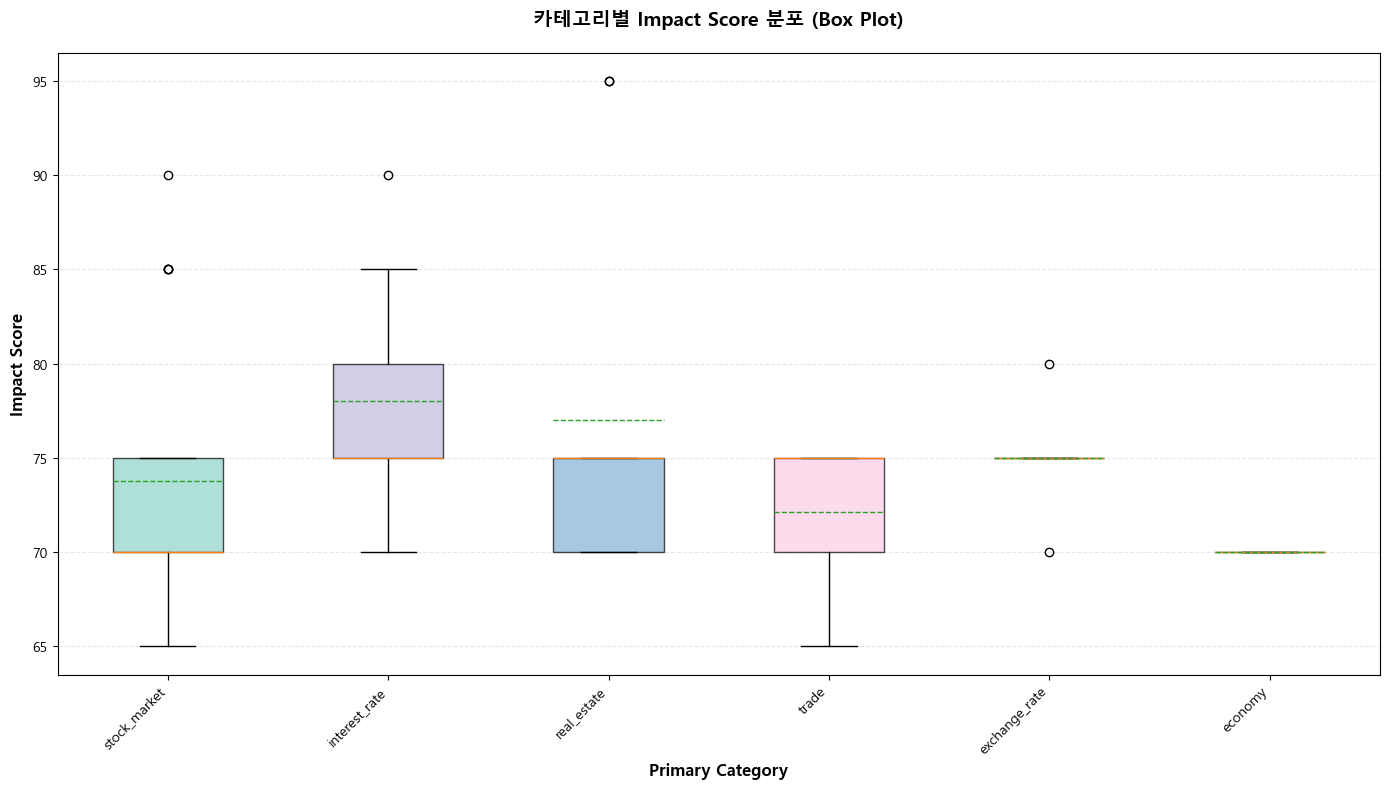

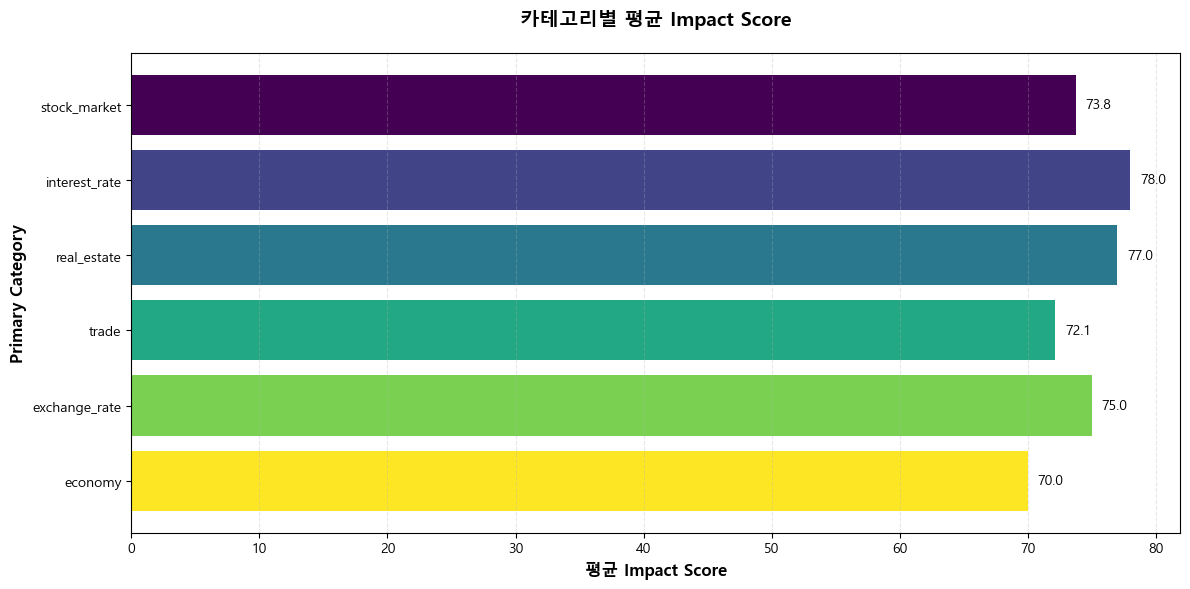

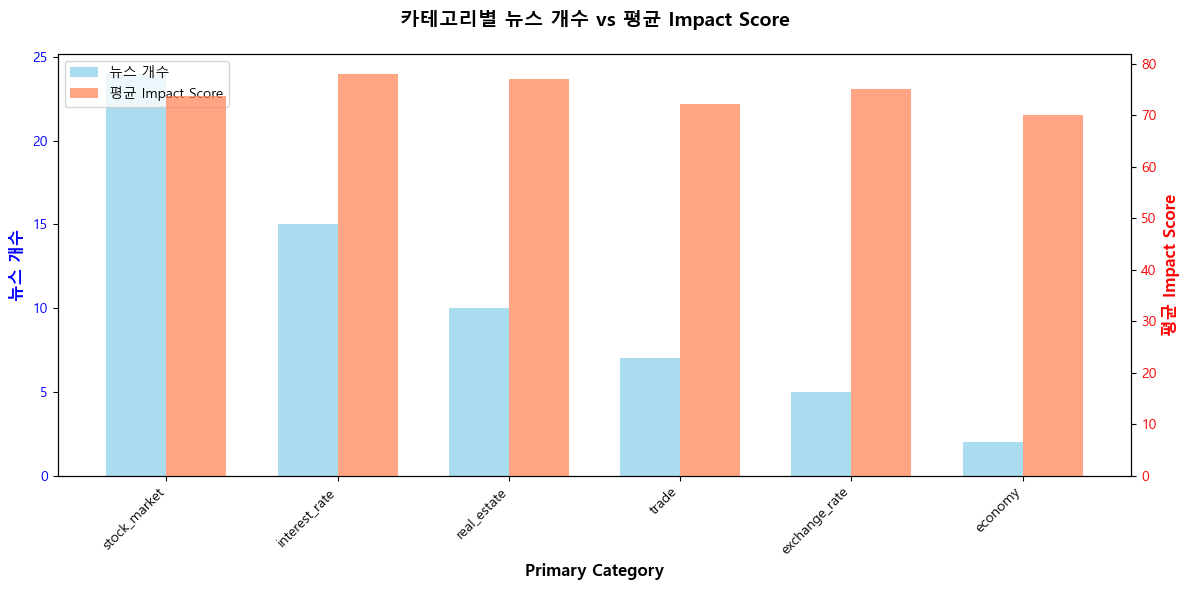



📈 카테고리별 Impact Score 상세 분석:

🔹 [stock_market]
   개수: 24개
   평균: 73.75
   중앙값: 70.00
   표준편차: 6.30
   범위: 65 ~ 90
   25% 분위수: 70.00
   75% 분위수: 75.00

🔹 [interest_rate]
   개수: 15개
   평균: 78.00
   중앙값: 75.00
   표준편차: 5.28
   범위: 70 ~ 90
   25% 분위수: 75.00
   75% 분위수: 80.00

🔹 [real_estate]
   개수: 10개
   평균: 77.00
   중앙값: 75.00
   표준편차: 9.78
   범위: 70 ~ 95
   25% 분위수: 70.00
   75% 분위수: 75.00

🔹 [trade]
   개수: 7개
   평균: 72.14
   중앙값: 75.00
   표준편차: 3.93
   범위: 65 ~ 75
   25% 분위수: 70.00
   75% 분위수: 75.00

🔹 [exchange_rate]
   개수: 5개
   평균: 75.00
   중앙값: 75.00
   표준편차: 3.54
   범위: 70 ~ 80
   25% 분위수: 75.00
   75% 분위수: 75.00

🔹 [economy]
   개수: 2개
   평균: 70.00
   중앙값: 70.00
   표준편차: 0.00
   범위: 70 ~ 70
   25% 분위수: 70.00
   75% 분위수: 70.00


In [16]:
# 예제: Primary Category별 Impact Score 분석
# 뉴스의 primary_category별로 impact_score의 분포를 분석하고 시각화합니다.

# 뉴스 데이터가 필요합니다 (Cell 25 실행 필요)
if 'news_df' not in globals() or news_df.empty:
    print("⚠️ 먼저 Cell 25를 실행하여 news_df를 생성하세요.")
else:
    # primary_category 컬럼 확인
    if 'primary_category' in news_df.columns and 'impact_score' in news_df.columns:
        # primary_category가 있는 데이터만 필터링
        category_data = news_df[
            news_df['primary_category'].notna() & 
            (news_df['primary_category'] != '') &
            news_df['impact_score'].notna()
        ].copy()
        
        if len(category_data) > 0:
            print("📊 Primary Category별 Impact Score 분석")
            print("="*80)
            
            # 카테고리별 통계 계산
            category_stats = category_data.groupby('primary_category')['impact_score'].agg([
                ('count', 'count'),
                ('mean', 'mean'),
                ('median', 'median'),
                ('std', 'std'),
                ('min', 'min'),
                ('max', 'max')
            ]).round(2)
            
            # 카운트 기준으로 정렬
            category_stats = category_stats.sort_values('count', ascending=False)
            
            print("\n📋 카테고리별 통계:")
            print(category_stats.to_string())
            
            # 카테고리별 개수
            print("\n" + "="*80)
            print("\n📊 카테고리별 뉴스 개수:")
            category_counts = category_data['primary_category'].value_counts()
            for category, count in category_counts.items():
                percentage = (count / len(category_data) * 100)
                print(f"  {category}: {count}개 ({percentage:.1f}%)")
            
            # 시각화 1: 카테고리별 Impact Score 박스플롯
            plt.figure(figsize=(14, 8))
            
            # 카테고리별 데이터 준비
            categories = category_stats.index.tolist()
            data_for_plot = [category_data[category_data['primary_category'] == cat]['impact_score'].values 
                           for cat in categories]
            
            # 박스플롯 생성
            bp = plt.boxplot(data_for_plot, labels=categories, patch_artist=True, 
                           showmeans=True, meanline=True)
            
            # 박스 색상 설정
            colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            plt.xlabel('Primary Category', fontsize=12, fontweight='bold')
            plt.ylabel('Impact Score', fontsize=12, fontweight='bold')
            plt.title('카테고리별 Impact Score 분포 (Box Plot)', fontsize=14, fontweight='bold', pad=20)
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', alpha=0.3, linestyle='--')
            plt.tight_layout()
            plt.show()
            
            # 시각화 2: 카테고리별 평균 Impact Score 바 그래프
            plt.figure(figsize=(12, 6))
            bars = plt.barh(range(len(category_stats)), category_stats['mean'].values, 
                          color=plt.cm.viridis(np.linspace(0, 1, len(category_stats))))
            
            plt.yticks(range(len(category_stats)), category_stats.index)
            plt.xlabel('평균 Impact Score', fontsize=12, fontweight='bold')
            plt.ylabel('Primary Category', fontsize=12, fontweight='bold')
            plt.title('카테고리별 평균 Impact Score', fontsize=14, fontweight='bold', pad=20)
            plt.gca().invert_yaxis()
            
            # 각 막대에 값 표시
            for i, (bar, value) in enumerate(zip(bars, category_stats['mean'].values)):
                plt.text(value + max(category_stats['mean'].values) * 0.01, i, 
                        f'{value:.1f}', va='center', fontsize=10)
            
            plt.grid(axis='x', alpha=0.3, linestyle='--')
            plt.tight_layout()
            plt.show()
            
            # 시각화 3: 카테고리별 뉴스 개수와 평균 Impact Score 비교
            fig, ax1 = plt.subplots(figsize=(12, 6))
            
            x = range(len(category_stats))
            width = 0.35
            
            # 막대 그래프 1: 개수
            bars1 = ax1.bar([i - width/2 for i in x], category_stats['count'].values, 
                          width, label='뉴스 개수', color='skyblue', alpha=0.7)
            ax1.set_xlabel('Primary Category', fontsize=12, fontweight='bold')
            ax1.set_ylabel('뉴스 개수', fontsize=12, fontweight='bold', color='blue')
            ax1.tick_params(axis='y', labelcolor='blue')
            ax1.set_xticks(x)
            ax1.set_xticklabels(category_stats.index, rotation=45, ha='right')
            
            # 막대 그래프 2: 평균 Impact Score (오른쪽 Y축)
            ax2 = ax1.twinx()
            bars2 = ax2.bar([i + width/2 for i in x], category_stats['mean'].values, 
                          width, label='평균 Impact Score', color='coral', alpha=0.7)
            ax2.set_ylabel('평균 Impact Score', fontsize=12, fontweight='bold', color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            
            # 범례
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
            
            plt.title('카테고리별 뉴스 개수 vs 평균 Impact Score', fontsize=14, fontweight='bold', pad=20)
            plt.tight_layout()
            plt.show()
            
            # 추가 통계: 카테고리별 Impact Score 분포 요약
            print("\n" + "="*80)
            print("\n📈 카테고리별 Impact Score 상세 분석:")
            for category in category_stats.index:
                cat_scores = category_data[category_data['primary_category'] == category]['impact_score']
                print(f"\n🔹 [{category}]")
                print(f"   개수: {len(cat_scores)}개")
                print(f"   평균: {cat_scores.mean():.2f}")
                print(f"   중앙값: {cat_scores.median():.2f}")
                print(f"   표준편차: {cat_scores.std():.2f}")
                print(f"   범위: {cat_scores.min():.0f} ~ {cat_scores.max():.0f}")
                print(f"   25% 분위수: {cat_scores.quantile(0.25):.2f}")
                print(f"   75% 분위수: {cat_scores.quantile(0.75):.2f}")
        else:
            print("ℹ️ primary_category 또는 impact_score가 있는 데이터가 없습니다.")
    else:
        missing_cols = []
        if 'primary_category' not in news_df.columns:
            missing_cols.append('primary_category')
        if 'impact_score' not in news_df.columns:
            missing_cols.append('impact_score')
        print(f"⚠️ 다음 컬럼이 없습니다: {missing_cols}")
        print(f"   사용 가능한 컬럼: {news_df.columns.tolist()}")
